/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


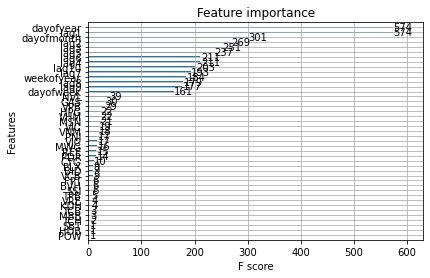

In [1]:
# Import liblary

import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV


# Read file price_train.csv and price_test.csv

df_train = pd.read_csv('/content/price_train.csv')
df_test = pd.read_csv('/content/price_test.csv')


# Add new feature from date feature

df_train = df_train.drop(columns=['open', 'high', 'low', 'volume'])
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['dayofweek'] = df_train['date'].dt.dayofweek
df_train['weekofyear'] = df_train['date'].dt.weekofyear
df_train['dayofyear'] = df_train['date'].dt.dayofyear
df_train['month'] = df_train['date'].dt.month
df_train['dayofyear'] = df_train['date'].dt.dayofyear
df_train['dayofmonth'] = df_train['date'].dt.day


# Fill NaN 

df_train = df_train.fillna(79.35)


# Add one hot feature from symbol feature
one_hot = pd.get_dummies(df_train.symbol)
df_train = pd.concat([df_train, one_hot], axis=1)
df_train = df_train.drop(columns='symbol')

# Add lag feature from close feature

df_train['lag1'] = df_train['close'].shift(1)
df_train['lag2'] = df_train['close'].shift(2)
df_train['lag3'] = df_train['close'].shift(3)
df_train['lag4'] = df_train['close'].shift(4)
df_train['lag5'] = df_train['close'].shift(5)
df_train['lag6'] = df_train['close'].shift(6)
df_train['lag7'] = df_train['close'].shift(7)
df_train['lag8'] = df_train['close'].shift(8)
df_train['lag9'] = df_train['close'].shift(9)
df_train['lag10'] = df_train['close'].shift(10)

# Drop row have NaN after add lag feature
df_train = df_train.drop(list(df_train[df_train['date'] == '2021-01-04'].index))
df_train = df_train.drop(list(df_train[df_train['date'] == '2021-01-05'].index))
df_train = df_train.drop(list(df_train[df_train['date'] == '2021-01-06'].index))
df_train = df_train.drop(list(df_train[df_train['date'] == '2021-01-07'].index))
df_train = df_train.drop(list(df_train[df_train['date'] == '2021-01-08'].index))
df_train = df_train.drop(list(df_train[df_train['date'] == '2021-01-09'].index))
df_train = df_train.drop(list(df_train[df_train['date'] == '2021-01-10'].index))
df_train = df_train.drop(list(df_train[df_train['date'] == '2021-01-11'].index))
df_train = df_train.drop(list(df_train[df_train['date'] == '2021-01-12'].index))
df_train = df_train.drop(list(df_train[df_train['date'] == '2021-01-13'].index))


# Create lag_init data to predict (10 last day row)

lag_init = df_train[df_train['date'] == '2021-10-29'].iloc[:,-10:].to_numpy()

# Drop date feature

df_train = df_train.drop(columns='date')
df_train = df_train.reset_index()
df_train = df_train.drop(columns='index')


# Drop close feature in test data frame

df_test = df_test.drop(columns='close')

# Add new feature from date feature

df_test['date'] = pd.to_datetime(df_test['date'])
df_test['dayofweek'] = df_test['date'].dt.dayofweek
df_test['weekofyear'] = df_test['date'].dt.weekofyear
df_test['dayofyear'] = df_test['date'].dt.dayofyear
df_test['month'] = df_test['date'].dt.month
df_test['dayofyear'] = df_test['date'].dt.dayofyear
df_test['dayofmonth'] = df_test['date'].dt.day


# Drop date feature

df_test = df_test.drop(columns='date')


# Add one hot feature from symbol feature

one_hot1 = pd.get_dummies(df_test.symbol)
df_test = pd.concat([df_test, one_hot1], axis=1)


# Drop symbol feature

df_test = df_test.drop(columns='symbol')


# Create a copy of test data frame

df_test1 = df_test.copy()


# Split data frame to train, valid data

feature, label = df_train.iloc[:, 1:], df_train.iloc[:, 0]
X_train, X_valid, y_train, y_valid = train_test_split(feature, label, test_size =0.3, shuffle=False)


# Train data with xgboost, plot feature important

reg = xgb.XGBRegressor(max_depth=3, n_estimators=600, objective='reg:squarederror')
#reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=0)
reg.fit(feature, label, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=0)
plot_importance(reg)


In [2]:
# Predict close feature
list_close = []
for symbol in range(30): # Predict close feature of symbol, one by one 
  prev_vals = lag_init[symbol, :]
  # forecast will be used to add data after predict
  forecast = prev_vals.copy()
  for i in range(21):
    X = df_test1.iloc[i:i+1].copy()
    # Add 10 lag feature to predict data
    for n in range(10):
      X.loc[:, 'lag' +str(n+1)] = forecast[n]
    # Predict
    est_scaled = reg.predict(X)
    # Add data after predict in next single day
    forecast = np.concatenate([np.array(est_scaled).reshape(1,), forecast])
  # Add predict data next 21 days of a symbol
  list_close.append(forecast[-21:])

ab = np.array([list_close]).reshape(630,)
a1 = pd.DataFrame(ab)


In [3]:
# Convert result data to file csv

submission = pd.read_csv('/content/price_test.csv')
submission.drop(columns='close')
submission['close'] = a1
submission['Id'] = submission[['date', 'symbol']].apply(lambda x: str(x[0])+':'+x[1], axis=1)
submission['Predicted'] = submission['close']
submission[['Id', 'Predicted']].to_csv('submission.csv', index=False)
